# Realizando _imports_

In [1]:
import os
import sys
from pathlib import Path

sys.path.append(
    os.path.join(
        Path(os.getcwd()).parents[1],
        "src"
    )
)

In [2]:
import csv
import numpy as np
import pandas as pd
import logging as lg

from sklearn.datasets import load_iris
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from models.ainet import AiNet

import networkx as nx
from scipy.sparse.csgraph import minimum_spanning_tree

# Definindo função pra _plotar_ o grafo apresentando suas respectivas conexões

In [3]:
def plot_mst_graph(ainet: AiNet, ex_list: np.ndarray, labels: np.array = np.array([])) -> None:
    tree = minimum_spanning_tree(ainet.antibody_distances)
    graph = nx.from_numpy_array(tree)

    str_ex_list = [f"{u}-{v}" for u, v in ex_list]
    
    ad_list = [(u, v) for (u, v, d) in graph.edges(data=True) if f"{u}-{v}" not in str_ex_list and f"{v}-{u}" not in str_ex_list]

    pos = {i:(a,b) for i, (a, b) in enumerate(ainet.antibody_population[:, :2])}
    
    if not labels.any():
        nx.draw_networkx_nodes(graph, pos, node_size=200, node_color="r")
        
    if labels.any():
        color_normalizer = matplotlib.colors.Normalize(labels.min(), labels.max())
        for label in set(labels):
            label_idxs = np.where(labels == label)[0]
            
            nx.draw_networkx_nodes(
                graph, 
                pos, 
                nodelist=label_idxs,
                node_size=200,
                node_color=[list(plt.colormaps["viridis"](color_normalizer(label)))],
                label=label
            )
            
        plt.legend()

    nx.draw_networkx_labels(graph, pos)
    nx.draw_networkx_edges(graph, pos, edgelist=ad_list)
    nx.draw_networkx_edges(graph, pos, edgelist=ex_list, edge_color="r", style="dashed")

    nx.draw_networkx_edge_labels(
        graph, 
        pos, 
        { 
            k: np.round(v, 2) 
             for k, v in nx.get_edge_attributes(graph, "weight").items()
        }
    )

In [4]:
plt.rcParams["axes.spines.top"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["axes.labelsize"] = "large"
# plt.rcParams["font.family"] = ["sans-serif"]

# Configurações e inicialização

In [5]:
root_log = lg.getLogger("root")

In [6]:
matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]
matplotlib.rcParams['axes.titlesize'] = 'large'
matplotlib.rcParams['axes.titleweight'] = 'bold'

In [7]:
title_dict = {"fontweight": "bold", "fontfamily":"monospace", "fontsize": 16}

# Experimentos realizados
<div>
    Para demonstrar o funcionamento do <span style="display:inline;font-size:1.15rem;font-weight:700">aiNet</span>, três conjuntos de dados diferentes foram usados, onde cada conjunto de dados serviu como entrada do algoritmo para seu treinamento (geração da rede de anticorpos) e posteriormente os mesmos dados foram agrupados pelo algortimo. Os dados utilizados foram :
</div>
<ol>
    <li>Iris</li>
    <li>Spiral (conjunto de dados obtido a partir de uma função matemática com o intuito de gerar dois grupos de dados no formato de uma espiral, sendo um grupo a espiral interna e o outro grupo a externa)</li>
    <li>Ruspini</li>
</ol>

<p>Devido a baixa dimensão dos dados utilizados nos experimentos a métrica de similaridade escolhida foi a distância euclidiana.</p>

<h2>Parâmetros Treinamento - aiNet<sup>*</sup></h2>
<ul>
    <li><i>@antigen_population</i>: np.ndarray &#8594 dados utilizados como entrada para o treinamento do algoritmo</li>
    <li><i>@number_of_antibodies</i>: int &#8594 tamanho inicial da população de anticorpos</li>
    <li><i>@no_best_cells_taken_each_selection</i>: int &#8594 quantidade de antígenos a serem selecionados após a avaliação de afinidade com o anticorpo</li>
    <li><i>@pruning_threshold</i>: float <b>(valor entre 0 e 1.0)</b> &#8594 limiar utlizado para eliminar (morte natural) de anticorpos que apresentam baixa similaridade com os antígenos</li>
    <li><i>@clone_number_multiplier</i>: int &#8594 quantidade de clones a serem gerados</li>
    <li><i>@suppression_threshold</i>: float <b>(valor entre 0 e 1.0)</b> &#8594 limiar utilizado para controlar a semelhança entre os antígenos</li>
</ul>

<sup>*</sup>Os parâmetros foram adaptados para o domínio de cada conjunto de dados, com exceção do parâmetro <i>@number_of_antibodies</i> que foi utilizado o valor de `12%` do tamanho do conjunto de dados a ser treinado.

<h2>Agrupamento - aiNet</h2>
<p>O agrupamento é realizado através de maneira hierárquica, utilizando o <abbr title="Minimum Spanning Tree">MST</abbr>,  onde cada grupo é gerado a partir da similaridade entre os objetos. Para este algoritmo é possível agrupar utilizando duas métricas:</p>
<ul>
    <li>Limiar &#8594 valor utilizado para <i>separar</i> elementos que apresentem uma distância média maior que o limiar selecionado.</li>
    <li>$k$ &#8594 número de desvios padrões utilizado como limiar para <i>separar</i> elementos</li>
</ul>

<h3>Parâmetros Agrupamento - aiNet</h3>
<ul>
    <li><i>@predict_data</i>: np.ndarray &#8594 dados a serem agrupados pelo algoritmo</li>
    <li><i>@mst_pruning_threshold</i>: float &#8594 limiar de <i>corte</i></li>
    <li><i>@mst_pruning_type</i>: "average" | "threshold" &#8594 parâmetro necessário para indicar qual metódo a ser utilizado</li>
    <li><i>@k</i>: float &#8594 número de desvios padrões a serem considerados</li>
    <li><i>@minimum_no_edges</i>: int &#8594 quantidade mínima de <i>ligações</i> necessárias para avaliar o elemento</li>
</ul>




## Iris 

### Carregando dados

In [8]:
iris = load_iris()
data = iris.data
target = iris.target

target_name = iris.target_names

### Normalização dos dados

In [9]:
scaler = MinMaxScaler()

normed_data = scaler.fit_transform(data[:, :2])

In [10]:
normed_data[:5, :]

array([[0.22222222, 0.625     ],
       [0.16666667, 0.41666667],
       [0.11111111, 0.5       ],
       [0.08333333, 0.45833333],
       [0.19444444, 0.66666667]])

### Dimensão dos dados

In [11]:
normed_data.shape

(150, 2)

### Treinando aiNet

In [12]:
ainet = AiNet(root_log, distance_method="euclidean")

In [13]:
ainet.fit(
    normed_data[:, :2],
    np.ceil(0.12 * normed_data.shape[0]).astype(int),
    no_best_cells_taken_each_selection=5,
    clone_multiplier=5,
    pruning_threshold=0.05,
    percent_clones_reselected=0.10,
    suppression_threshold=0.15
)

iter: 100 | cur_hyper_rate:  0.00000000 | |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% | avd: 0.03143 | net size: 13


### Dimensão da população gerada após o treinamento

In [14]:
ab_population = ainet.antibody_population

ab_population.shape

(13, 2)

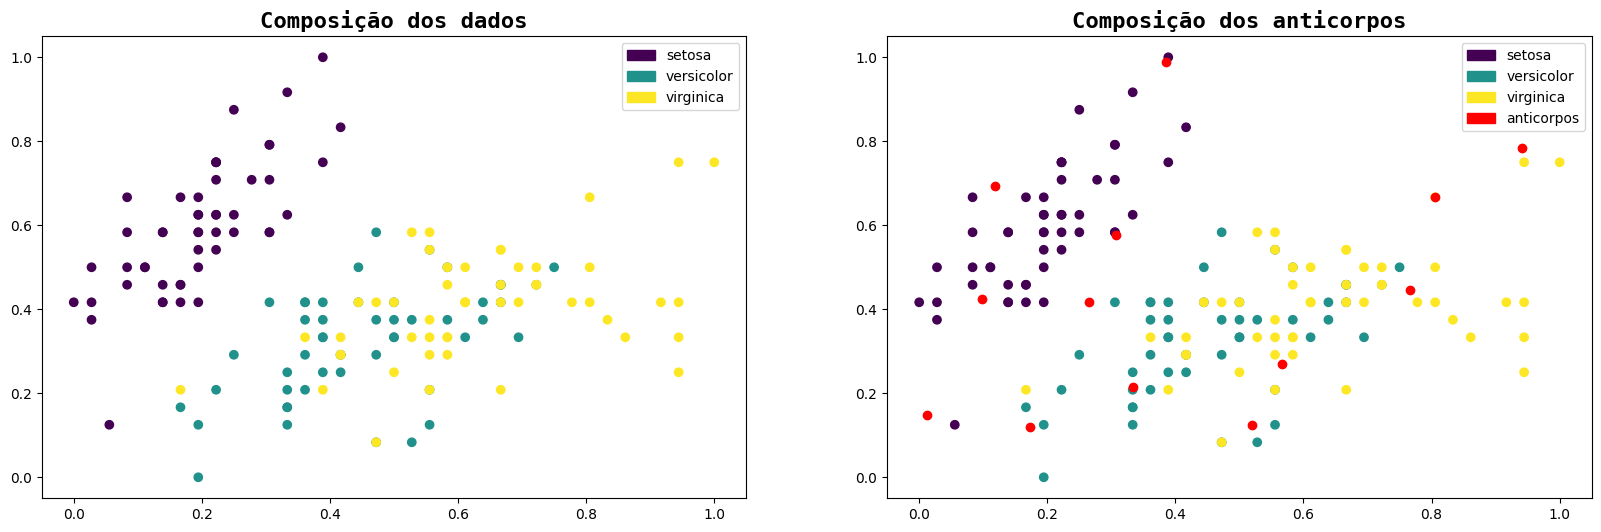

In [15]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Composição dos dados", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(122)

ab_x, ab_y = np.split(ab_population, 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])]

ax = plt.scatter(ab_x, ab_y, color="red")

plt.title("Composição dos anticorpos", fontdict=title_dict)
plt.legend(handles=[*handles, mpatches.Patch(color="red", label="anticorpos")], loc="upper right")

### Realizando agrupamento

#### Por limiar

In [16]:
mst_pruning_threshold = 0.07

##### Agrupamento obtido

In [17]:
t_labels = ainet.predict(normed_data[:, :2], mst_pruning_threshold=mst_pruning_threshold, mst_pruning_type="threshold")
print(f"Total de grupos encontrado: {len(np.unique(t_labels))}")
t_labels

Total de grupos encontrado: 5


array([3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1,
       1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 1, 2, 3, 1,
       1, 3, 1, 3, 3, 3, 4, 4, 4, 3, 4, 3, 4, 2, 4, 3, 2, 3, 4, 4, 3, 4,
       3, 3, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 4, 3, 3, 4, 4,
       3, 3, 3, 4, 3, 2, 3, 3, 3, 4, 2, 3, 4, 3, 4, 4, 4, 4, 2, 4, 4, 0,
       4, 4, 4, 3, 3, 4, 4, 0, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 3], dtype=int8)

##### Quantidade de vértices eliminados

In [18]:
t_ex_edges = ainet.mst_edges_deleted

t_ex_edges.shape

(8, 2)

In [19]:
t_antibody_labels = ainet.antibody_labels
t_antibody_labels.shape

(13,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

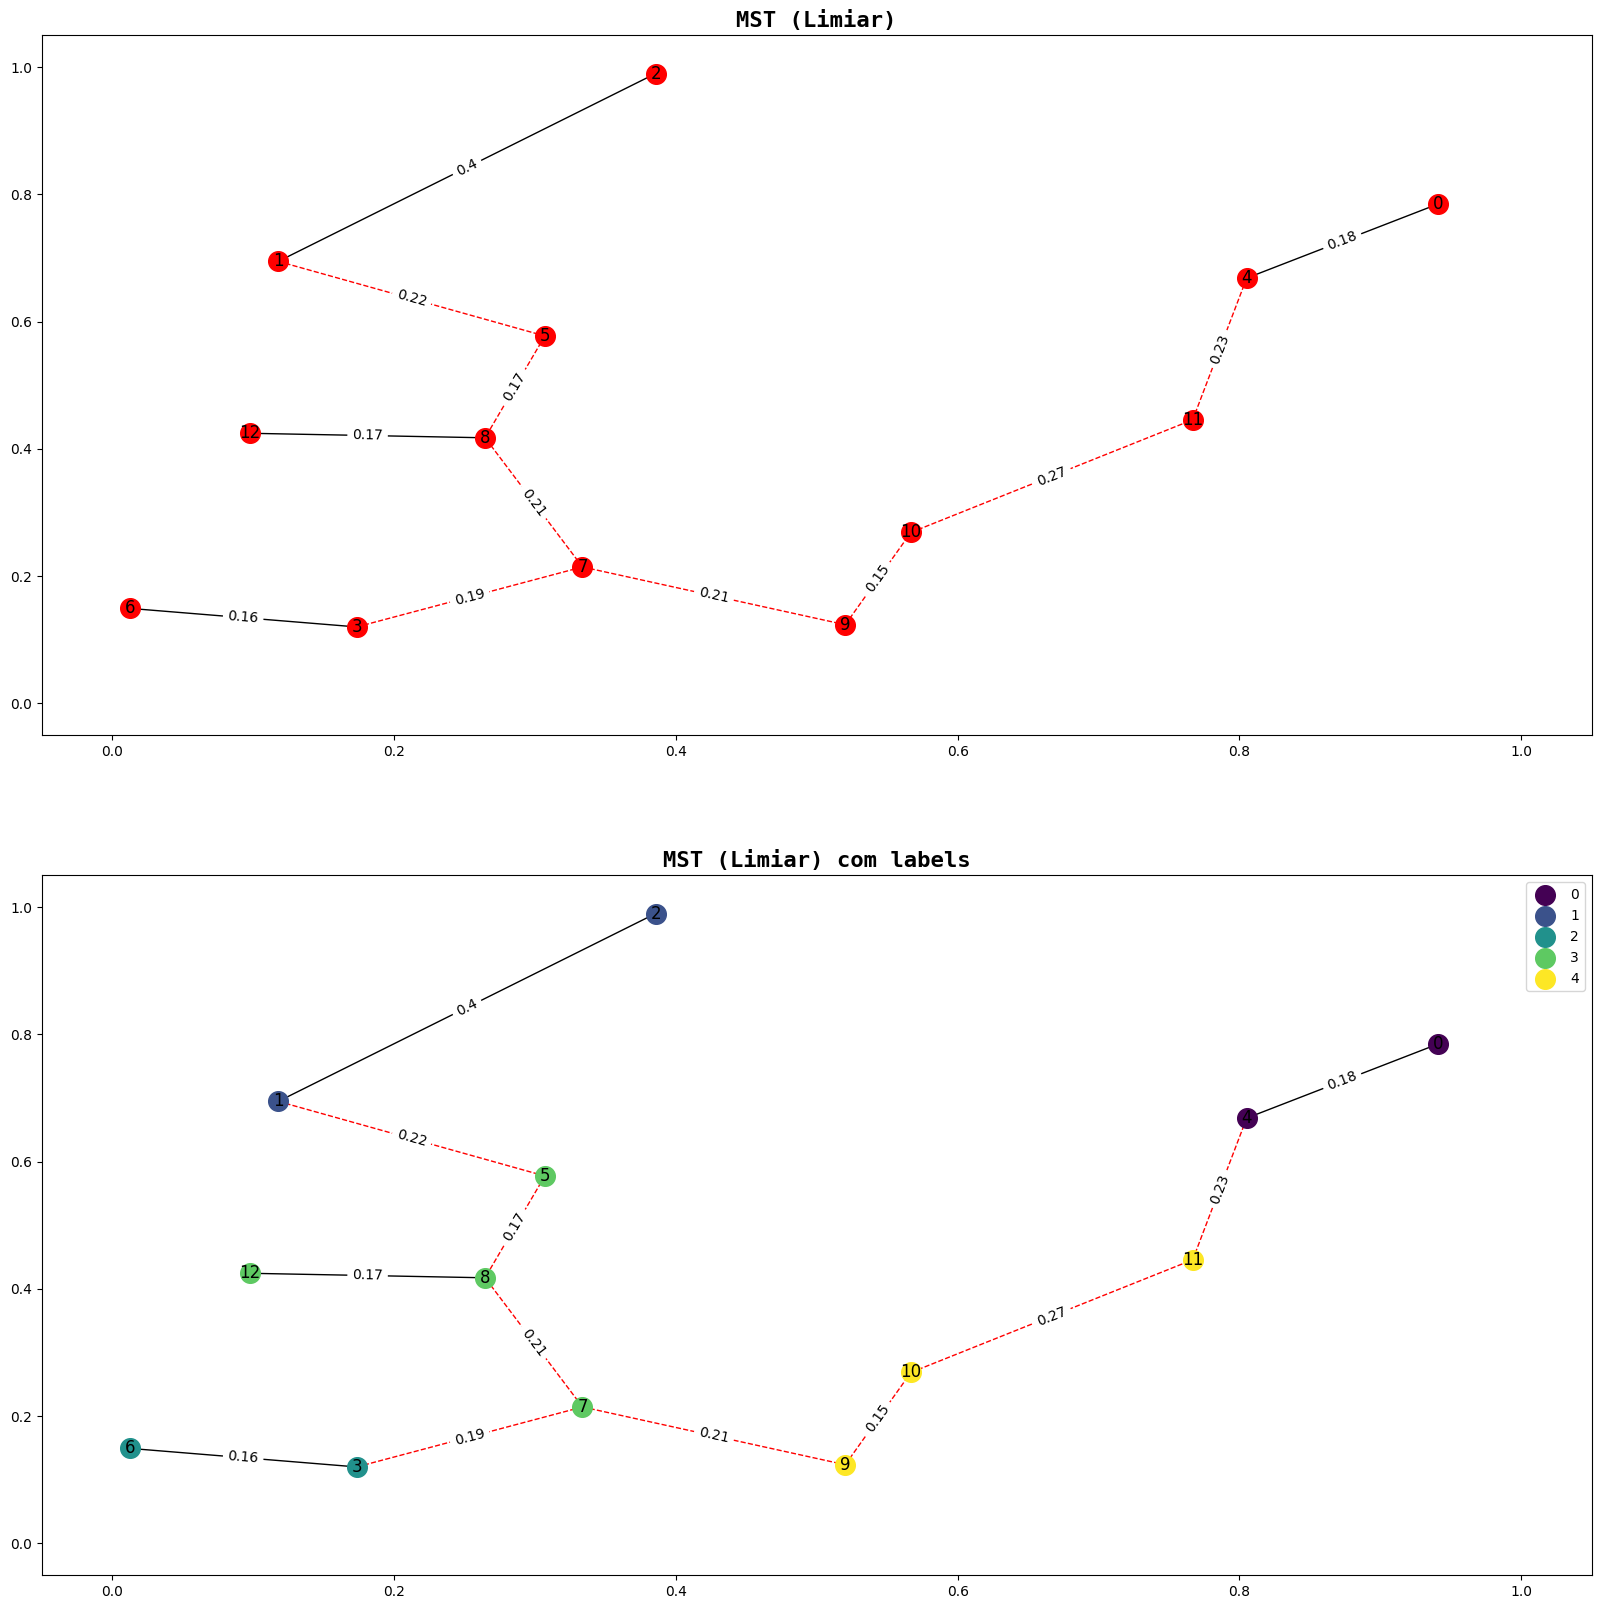

In [20]:
plt.figure(figsize=(20, 20))
plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges)

plt.title("MST (Limiar)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges, t_antibody_labels)

plt.title("MST (Limiar) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### Por Desvio Padrão

In [21]:
mst_pruning_param = 2.5

##### Agrupamento obtido

In [22]:
labels = ainet.predict(normed_data[:, :2], k=mst_pruning_param, mst_pruning_type="average")
print(f"Total de grupos encontrado: {len(np.unique(labels))}")
labels

Total de grupos encontrado: 2


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1], dtype=int8)

##### Quantidade de vértices eliminados

In [23]:
ex_edges = ainet.mst_edges_deleted
ex_edges.shape

(1, 2)

In [24]:
antibody_labels = ainet.antibody_labels
antibody_labels.shape

(13,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

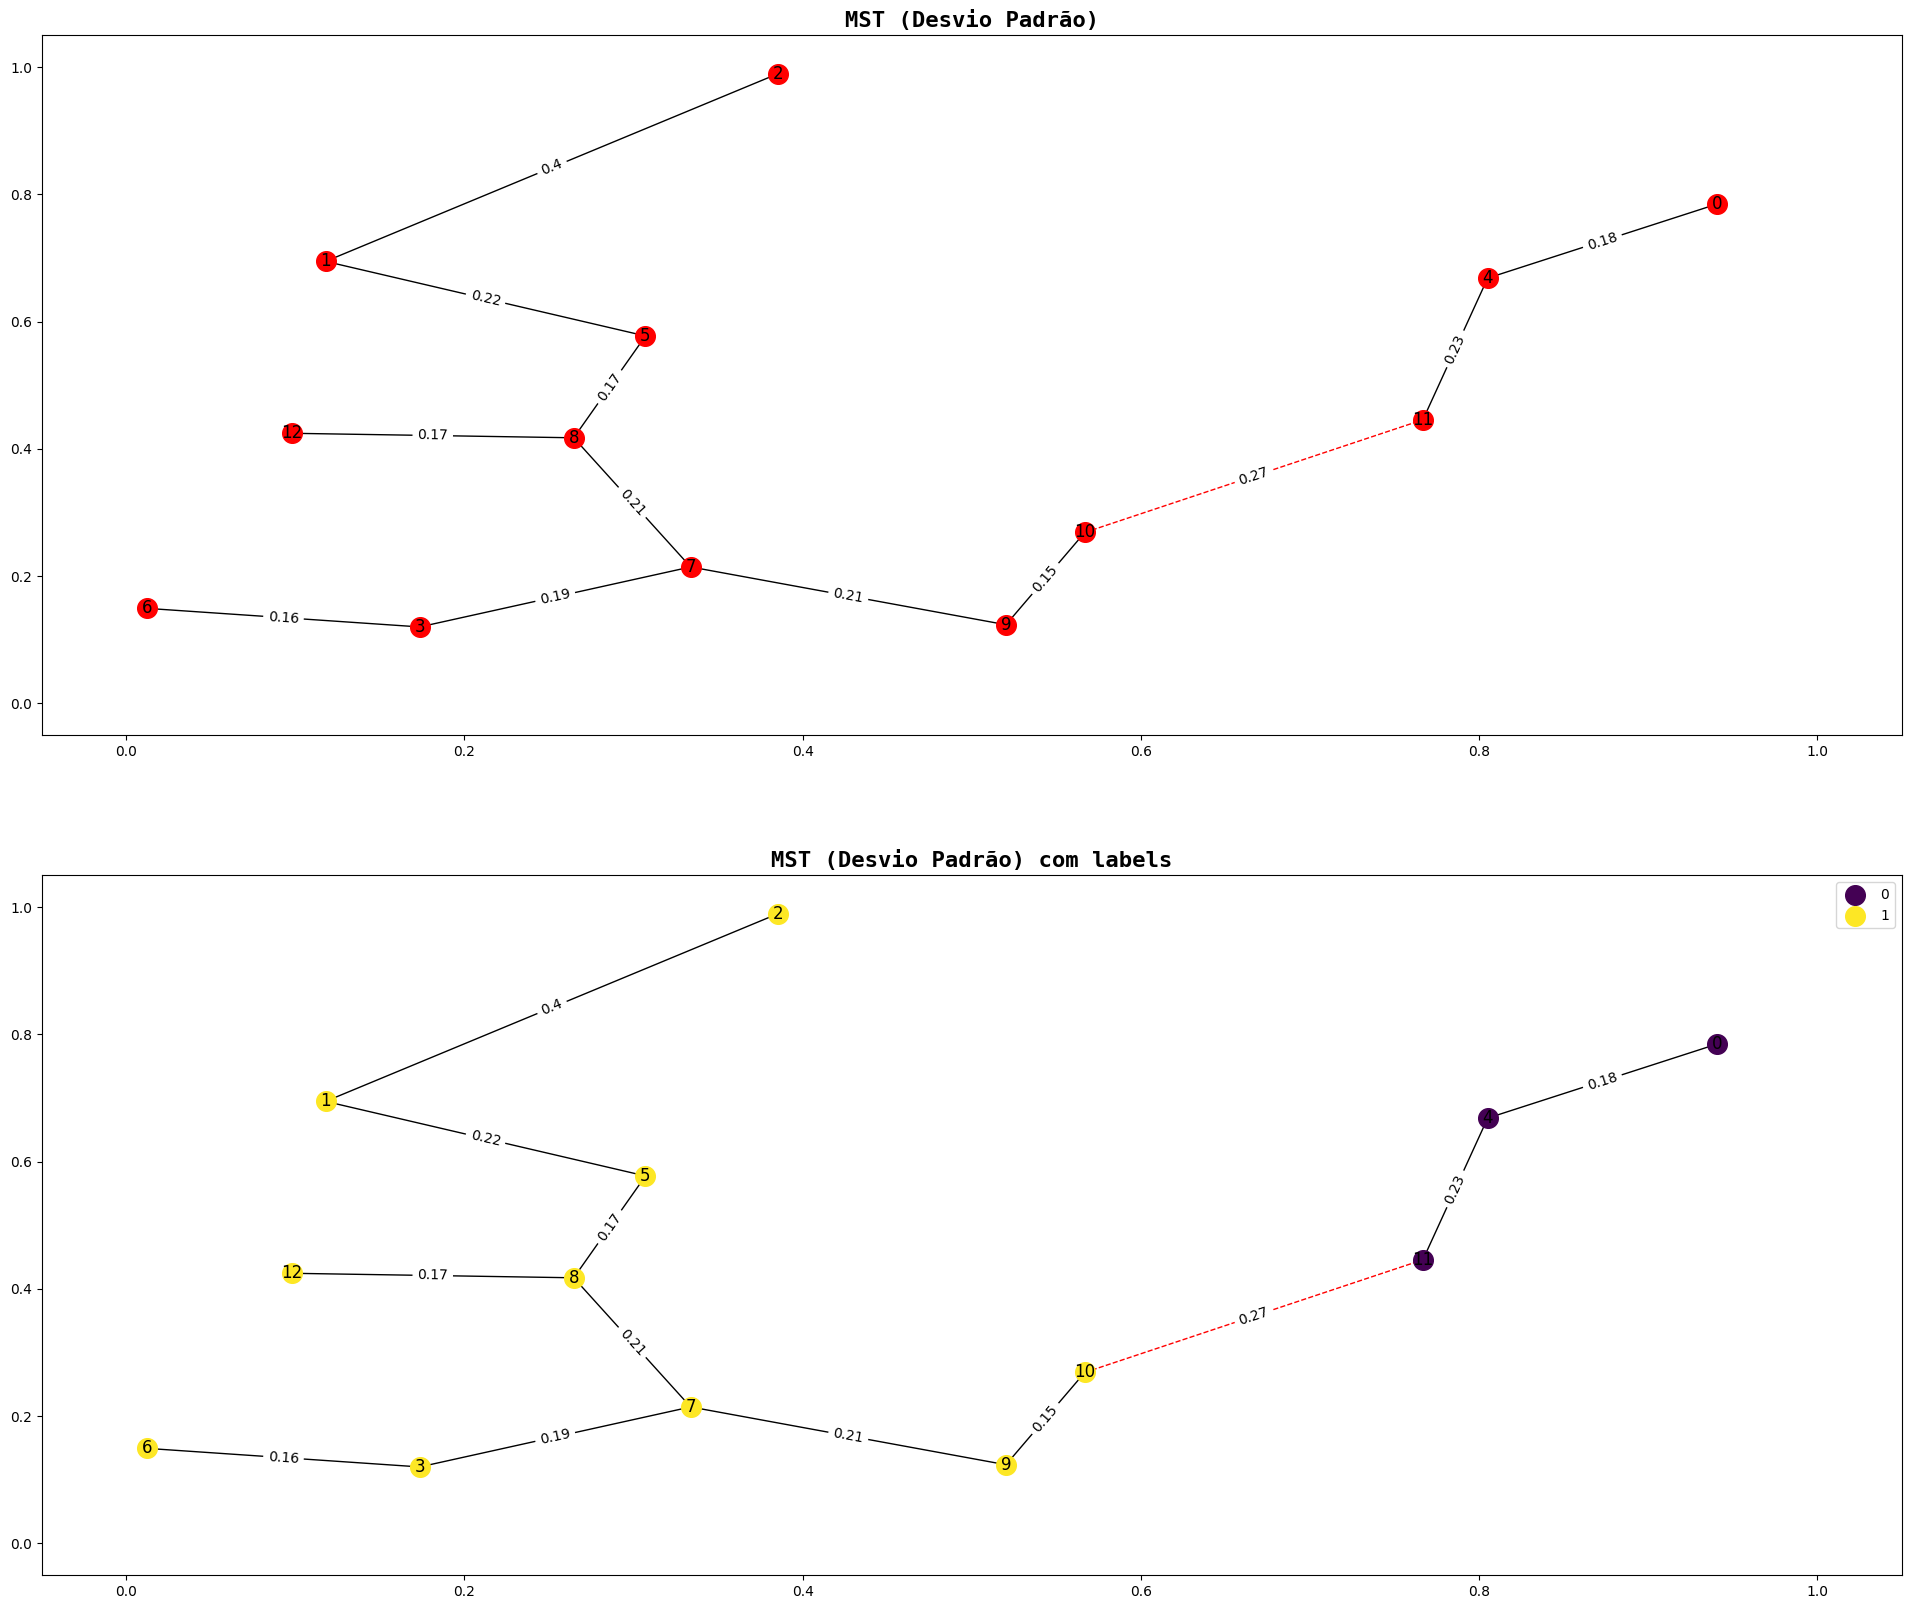

In [25]:
plt.figure(figsize=(24, 20))
plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges)

plt.title("MST (Desvio Padrão)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges, antibody_labels)

plt.title("MST (Desvio Padrão) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### Comparação classificação

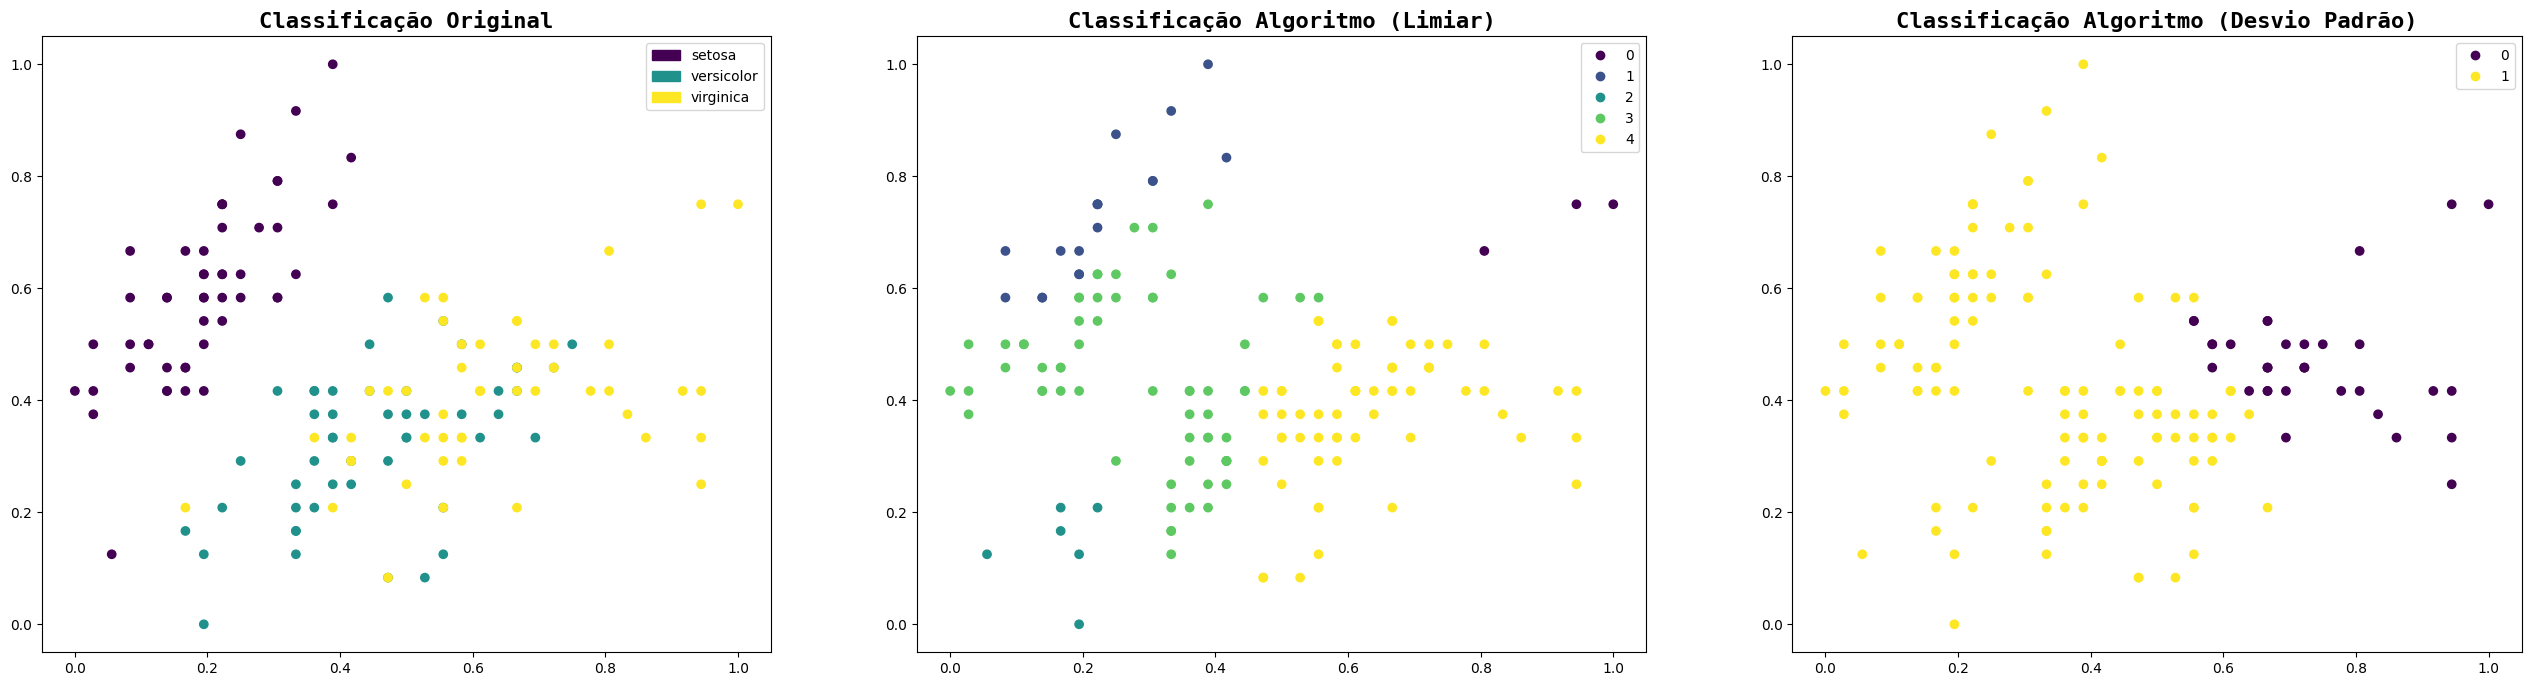

In [26]:
plt.figure(figsize=(32, 8))

plt.subplot(131)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Classificação Original", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(132)

scatter = plt.scatter(data_x, data_y, c=t_labels, cmap="viridis")
plt.title("Classificação Algoritmo (Limiar)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(t_labels), loc="upper right")

plt.subplot(133)

scatter = plt.scatter(data_x, data_y, c=labels, cmap="viridis")
plt.title("Classificação Algoritmo (Desvio Padrão)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="upper right")

## Spiral dataset

### Função para gerar os dados

In [27]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

### Carregando dados

In [28]:
data, target = twospirals(200, noise=0.5)

target_name = ["A", "B"]

### Normalização dos dados

In [29]:
scaler = MinMaxScaler()

normed_data = scaler.fit_transform(data[:, :2])

In [30]:
normed_data[:5, :]

array([[0.03074769, 0.36923836],
       [0.83113816, 0.66957197],
       [0.08263696, 0.83420055],
       [0.62175937, 0.0745976 ],
       [0.26069605, 0.60405903]])

### Dimensão dos dados

In [31]:
normed_data.shape

(400, 2)

### Treinando aiNet

In [32]:
ainet = AiNet(logger=root_log, distance_method="euclidean")

In [33]:
ainet.fit(
    normed_data[:, :2],
    90,
    no_best_cells_taken_each_selection=10,
    clone_multiplier=9,
    pruning_threshold=0.022,
    percent_clones_reselected=0.20,
    suppression_threshold=0.12,
    max_iter=100
)

iter: 100 | cur_hyper_rate:  0.00000000 | |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% | avd: 0.01376 | net size: 28


### Dimensão da população gerada após o treinamento

In [34]:
ab_population = ainet.antibody_population

ab_population.shape

(28, 2)

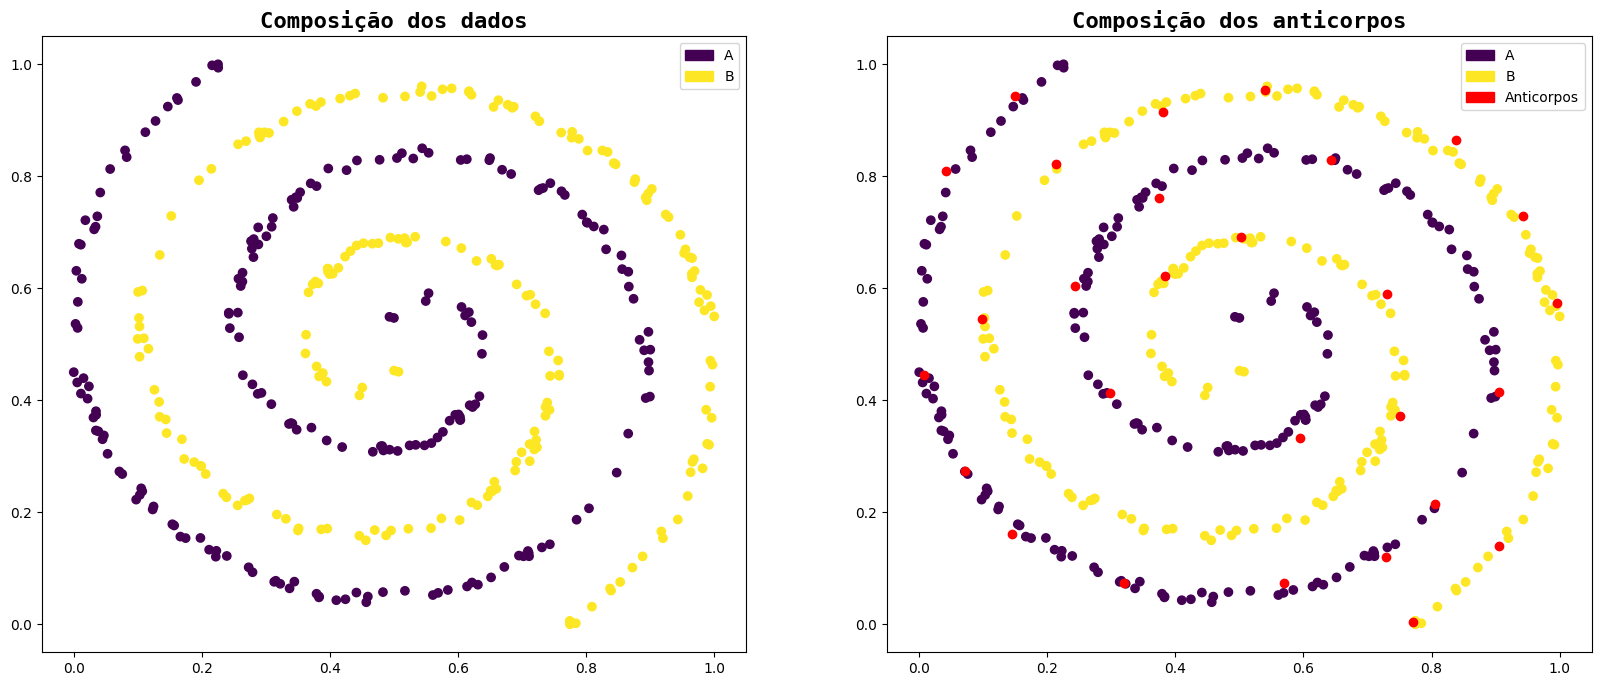

In [35]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Composição dos dados", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(122)

ab_x, ab_y = np.split(ab_population, 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])]

ax = plt.scatter(ab_x, ab_y, color="red")

plt.title("Composição dos anticorpos", fontdict=title_dict)
plt.legend(handles=[*handles, mpatches.Patch(color="red", label="Anticorpos")])

### Realizando agrupamento

#### Por limiar

In [36]:
mst_pruning_threshold = 0.3

##### Agrupamento obtido

In [37]:
euclidean_distances(ainet.antibody_population, normed_data[:, :2])

array([[0.9474957 , 0.19484891, 0.75659818, ..., 0.53189256, 0.82902141,
        0.49082627],
       [0.31689529, 0.59205553, 0.27961036, ..., 0.13042154, 0.45844933,
        0.54724879],
       [0.76510725, 0.24691613, 0.5598308 , ..., 0.34889383, 0.70730031,
        0.45709141],
       ...,
       [0.43477019, 0.44933821, 0.36865897, ..., 0.0188696 , 0.45274999,
        0.43110306],
       [0.52126012, 0.46644026, 0.30014074, ..., 0.15449823, 0.59223518,
        0.52874731],
       [0.27087418, 0.59176651, 0.47363256, ..., 0.2085996 , 0.25840953,
        0.44565343]])

In [38]:
ainet.antibody_population.shape

(28, 2)

1


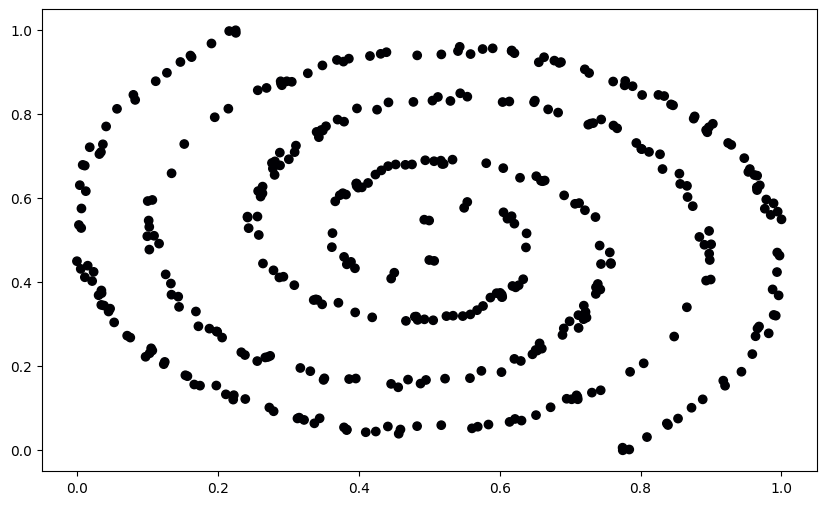

In [39]:
from sklearn.cluster import AgglomerativeClustering
from scipy.sparse.csgraph import minimum_spanning_tree

agg = AgglomerativeClustering(
    n_clusters=None, 
    compute_full_tree=True, 
    metric='euclidean', 
    distance_threshold=0.1, 
    linkage="average", 
    connectivity=minimum_spanning_tree(euclidean_distances(normed_data[:, :2], normed_data[:, :2])).toarray()
)

agg.fit(normed_data[:, :2])

print(len(np.unique(agg.labels_)))
    
plt.scatter(normed_data[:, 0], normed_data[:, 1], c=agg.labels_, cmap="magma")

In [40]:
t_labels = ainet.predict(normed_data[:, :2], mst_pruning_threshold=0.17, mst_pruning_type="threshold")
print(f"Total de grupos encontrado: {len(np.unique(t_labels))}")
t_labels

Total de grupos encontrado: 5


array([0, 0, 4, 1, 0, 1, 2, 4, 3, 2, 1, 1, 4, 0, 0, 2, 1, 3, 3, 0, 3, 0,
       0, 1, 1, 1, 3, 4, 0, 2, 0, 1, 0, 4, 1, 1, 0, 3, 1, 1, 1, 1, 0, 0,
       4, 2, 3, 1, 0, 0, 0, 2, 0, 0, 3, 0, 3, 0, 1, 3, 0, 1, 0, 1, 0, 4,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 1, 1, 4, 0, 4, 3, 0,
       1, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 1, 1, 4, 4, 1, 0, 0, 4, 0, 0, 2,
       0, 1, 3, 0, 0, 0, 4, 0, 0, 1, 0, 0, 1, 0, 0, 3, 1, 0, 0, 0, 3, 0,
       0, 0, 3, 1, 0, 3, 1, 0, 1, 3, 3, 1, 2, 0, 0, 0, 4, 1, 3, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 2, 0, 4, 1, 0, 0, 0, 3, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 2, 0, 0, 4, 3, 0, 0, 1, 0, 0, 4, 0, 0, 1, 1, 4, 3, 0, 1,
       0, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 3, 0, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0,
       0, 1, 2, 0, 1, 2, 0, 0, 3, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 2, 1, 3, 0, 0, 0, 2, 0, 0,

##### Quantidade de vértices eliminados

In [41]:
t_ex_edges = ainet.mst_edges_deleted

t_ex_edges.shape

(4, 2)

In [42]:
t_antibody_labels = ainet.antibody_labels
t_antibody_labels.shape

(28,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

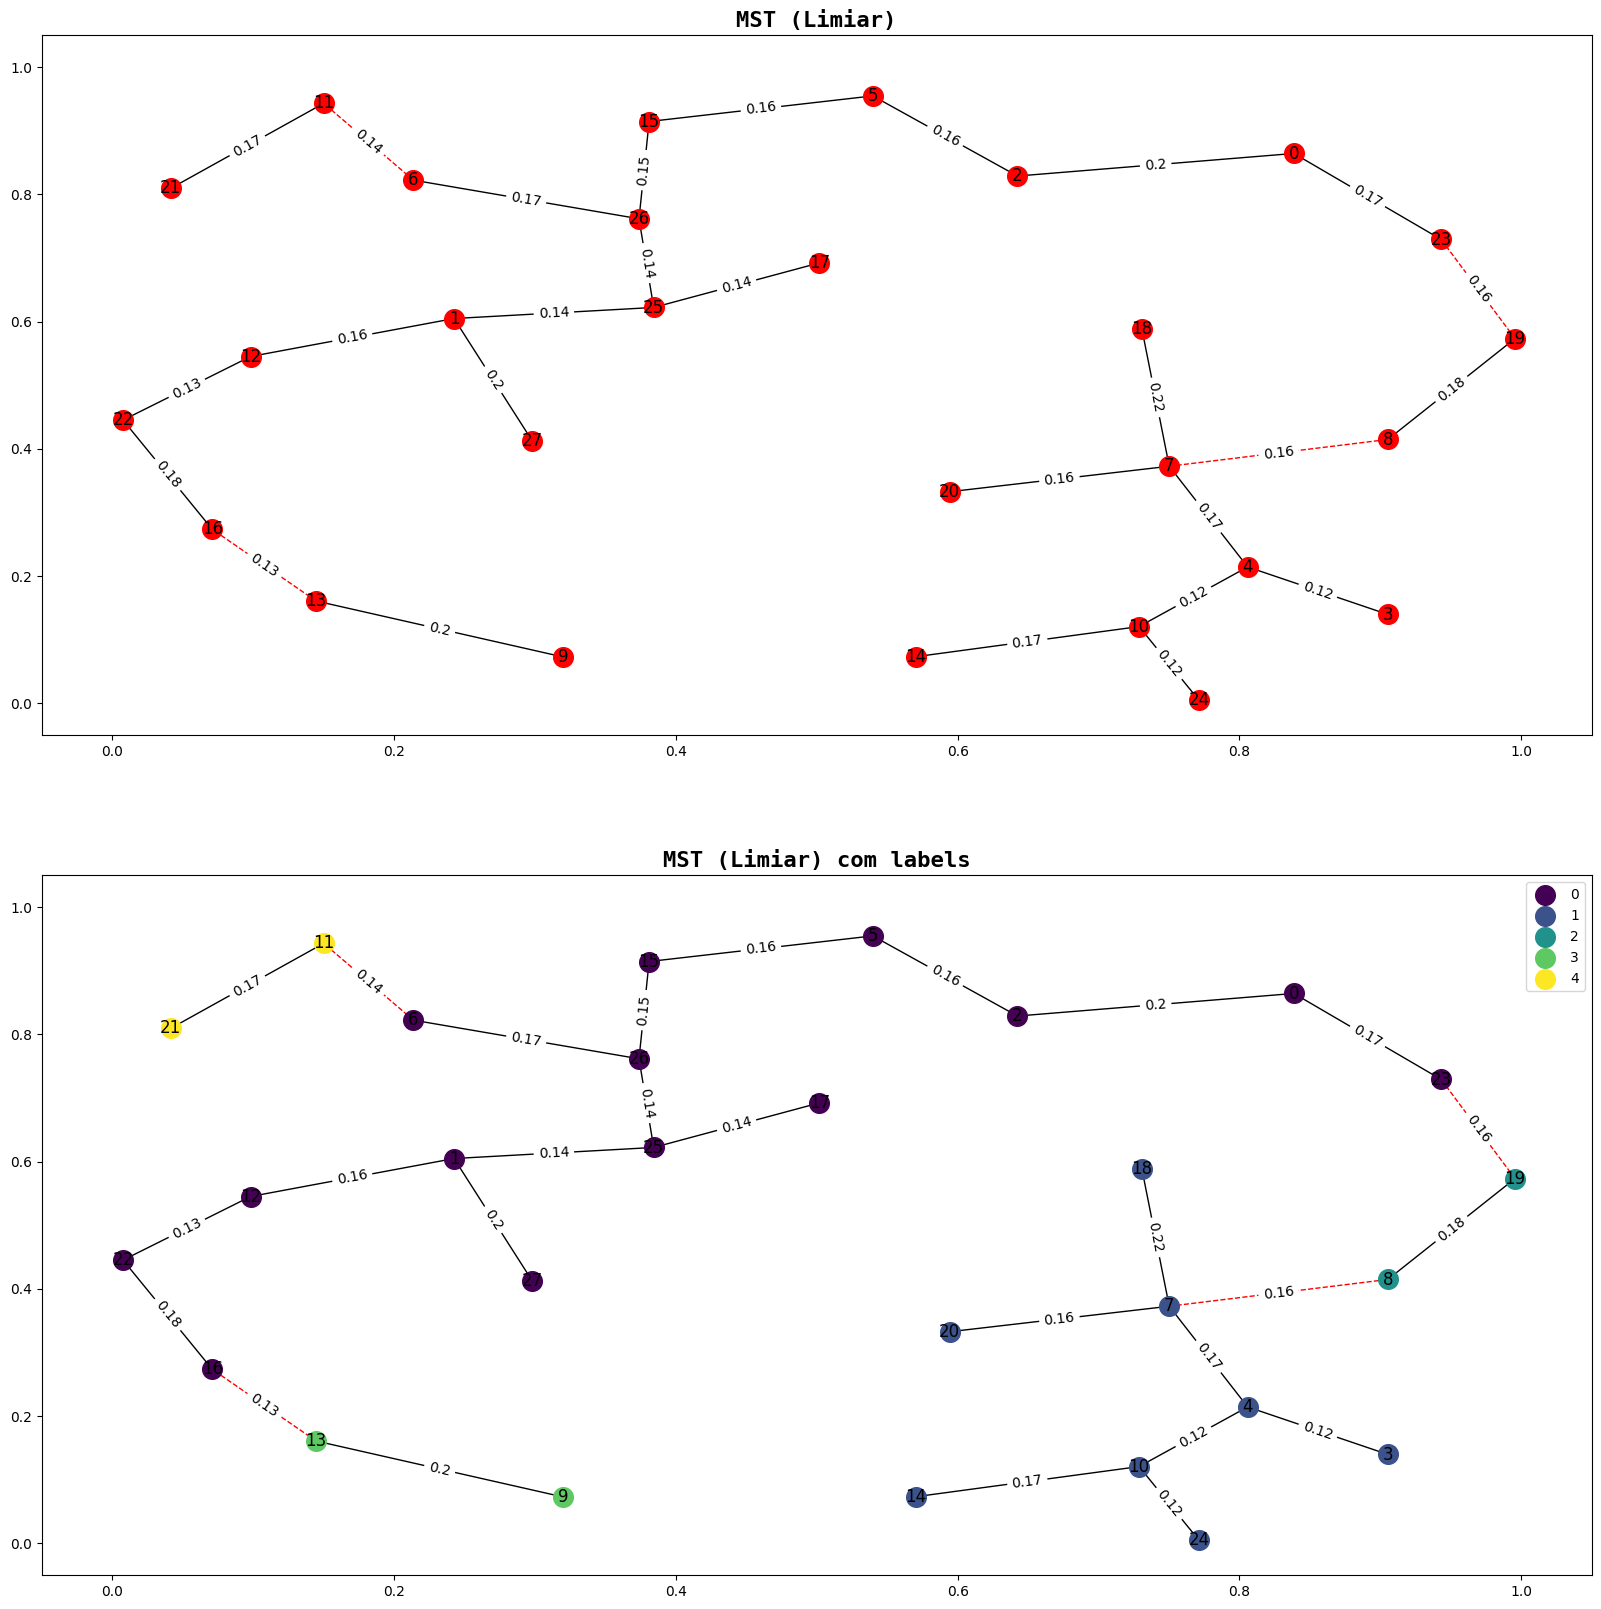

In [43]:
plt.figure(figsize=(20, 20))

plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges)

plt.title("MST (Limiar)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges, t_antibody_labels)

plt.title("MST (Limiar) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### Por Desvio Padrão

In [44]:
mst_pruning_param = 0.05

##### Agrupamento obtido

In [45]:
labels = ainet.predict(normed_data[:, :2], k=mst_pruning_param, mst_pruning_type="average")

print(f"Total de grupos encontrado: {len(np.unique(labels))}")
labels

Total de grupos encontrado: 6


array([1, 0, 4, 3, 1, 3, 3, 4, 5, 3, 3, 3, 4, 1, 0, 3, 3, 5, 5, 1, 5, 1,
       2, 3, 3, 3, 5, 4, 2, 3, 1, 3, 2, 4, 3, 3, 0, 5, 3, 3, 3, 3, 1, 5,
       4, 3, 5, 3, 1, 2, 1, 0, 1, 2, 5, 5, 5, 1, 3, 5, 0, 3, 2, 3, 5, 4,
       1, 5, 2, 1, 0, 3, 2, 1, 1, 3, 0, 1, 5, 3, 3, 3, 3, 4, 1, 4, 5, 1,
       3, 1, 1, 1, 1, 4, 0, 1, 5, 0, 1, 3, 3, 4, 4, 3, 1, 1, 4, 1, 1, 3,
       5, 3, 5, 1, 1, 1, 4, 1, 5, 3, 1, 2, 3, 1, 5, 5, 3, 0, 2, 2, 5, 1,
       2, 1, 5, 3, 1, 5, 3, 1, 3, 5, 5, 3, 3, 0, 1, 1, 4, 3, 5, 3, 3, 1,
       3, 1, 3, 1, 1, 1, 1, 3, 2, 4, 3, 1, 0, 5, 5, 2, 3, 1, 1, 1, 3, 1,
       1, 1, 3, 3, 1, 5, 4, 5, 1, 0, 3, 5, 1, 4, 1, 1, 3, 3, 4, 5, 5, 3,
       2, 1, 0, 5, 3, 1, 3, 1, 1, 3, 0, 1, 1, 1, 3, 3, 5, 1, 4, 2, 2, 3,
       0, 3, 3, 1, 1, 1, 2, 3, 5, 1, 0, 1, 3, 3, 4, 1, 5, 0, 4, 1, 1, 1,
       3, 0, 3, 1, 2, 1, 3, 3, 3, 1, 3, 5, 2, 0, 2, 3, 1, 0, 5, 2, 5, 1,
       0, 3, 0, 0, 3, 3, 1, 2, 5, 3, 0, 1, 5, 3, 0, 1, 1, 1, 1, 3, 3, 3,
       2, 1, 4, 3, 3, 3, 0, 3, 5, 1, 2, 5, 3, 1, 2,

##### Quantidade de vértices eliminados

In [46]:
ex_edges = ainet.mst_edges_deleted
ex_edges.shape

(5, 2)

In [47]:
antibody_labels = ainet.antibody_labels
antibody_labels.shape

(28,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

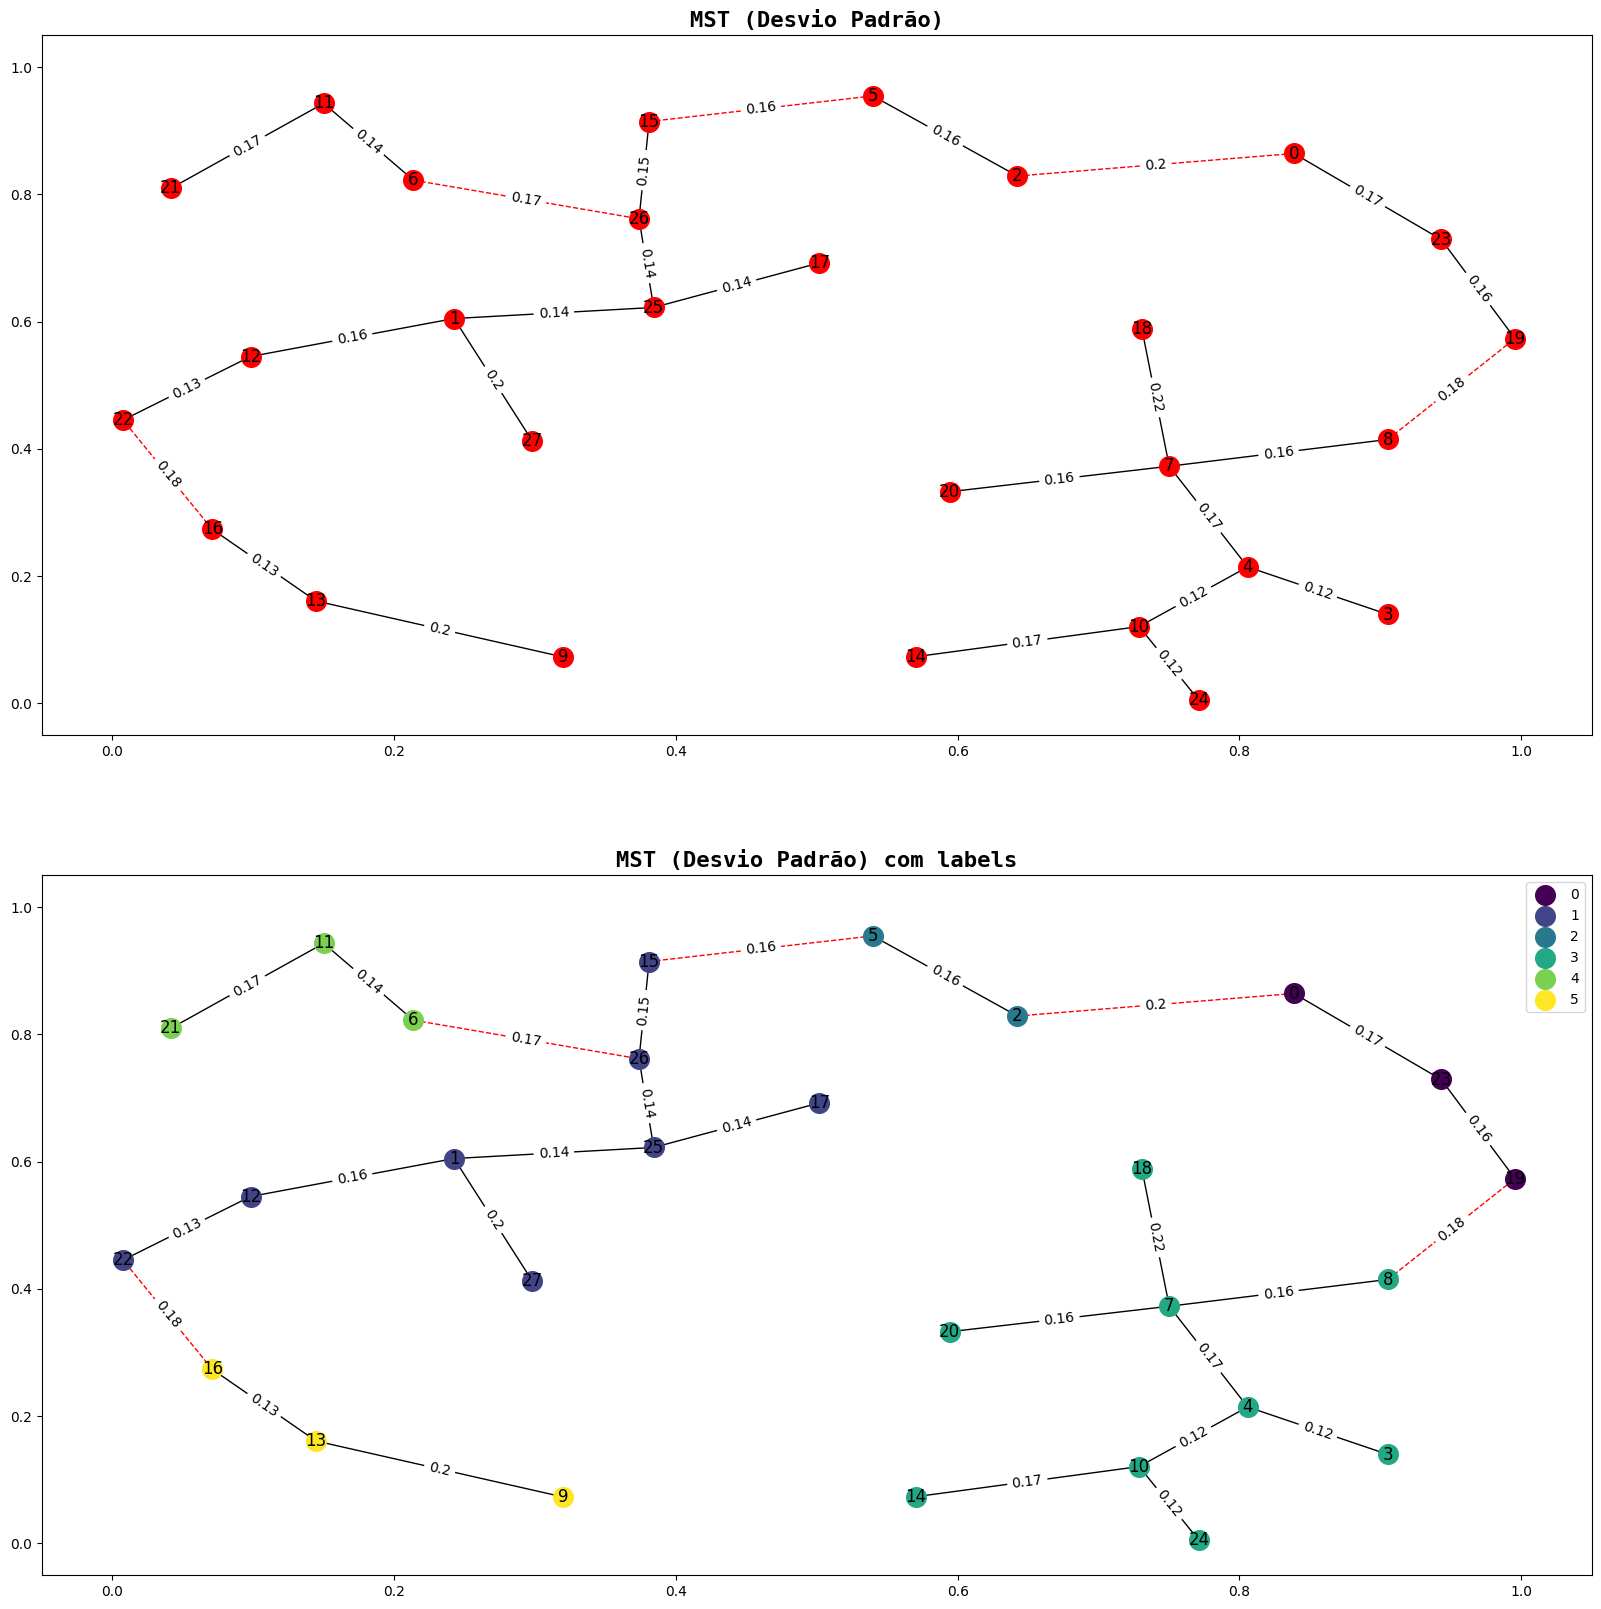

In [48]:
plt.figure(figsize=(20, 20))

plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges)

plt.title("MST (Desvio Padrão)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges, antibody_labels)

plt.title("MST (Desvio Padrão) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### Comparação classificação

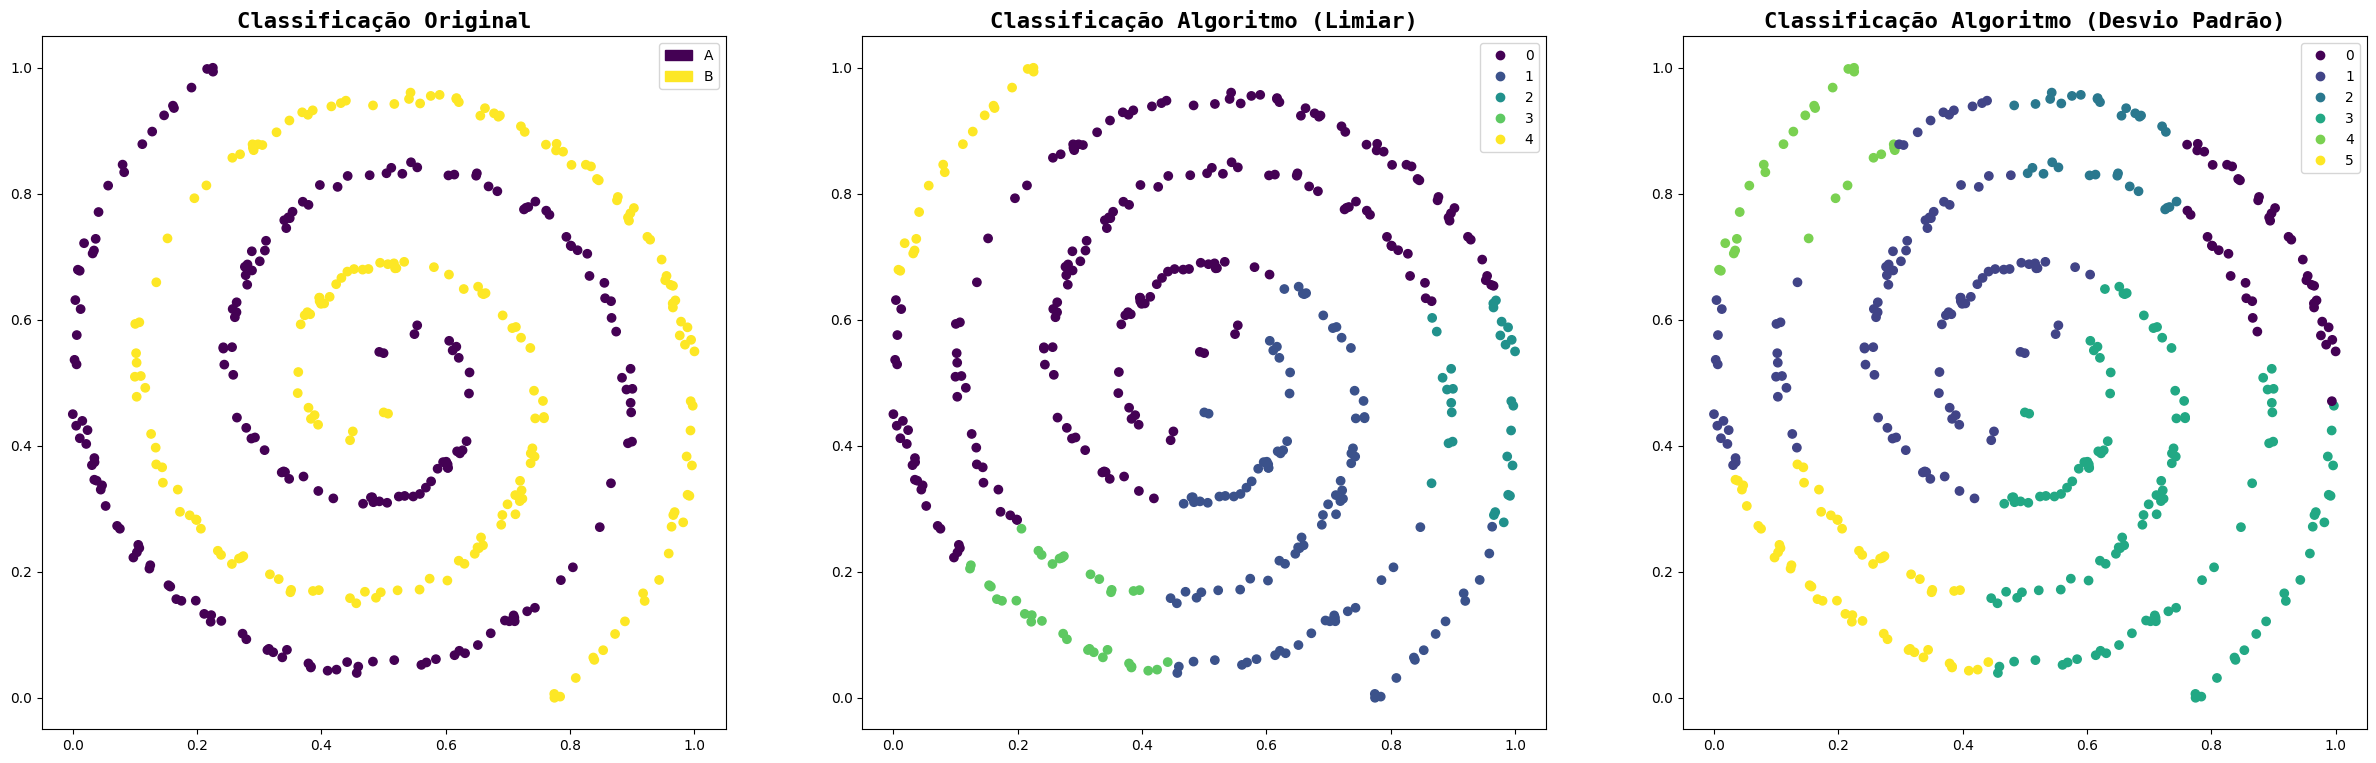

In [49]:
plt.figure(figsize=(30, 9))

plt.subplot(131)

data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Classificação Original", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(132)

scatter = plt.scatter(data_x, data_y, c=t_labels, cmap="viridis")
plt.title("Classificação Algoritmo (Limiar)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(t_labels), loc="upper right")

plt.subplot(133)

scatter = plt.scatter(data_x, data_y, c=labels, cmap="viridis")
plt.title("Classificação Algoritmo (Desvio Padrão)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="upper right")

## Ruspini

### Carregando dados

In [50]:
with open(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "shared", "datasets", "ruspini.csv"), "r+") as file:
    csv_data = csv.reader(file, quoting=csv.QUOTE_NONE, delimiter=";")
    data = [row for row in csv_data]
    header, *data = data

In [51]:
df = pd.DataFrame(columns=header, data=data).drop(columns=["Obj"])
df.head(2)

,Atr. 1,Atr. 2,Classe
0,4,53,A
1,5,63,A


#### Convertendo dados

In [52]:
df["Atr. 1"] = df["Atr. 1"].astype(int)
df["Atr. 2"] = df["Atr. 2"].astype(int)

df.head(2)

,Atr. 1,Atr. 2,Classe
0,4,53,A
1,5,63,A


In [53]:
data = df.iloc[:, :2].values

target_name = df["Classe"].unique()

target = np.array([ord(value.casefold()) - 97 for value in df["Classe"]])

### Normalização dos dados

In [54]:
scaler = MinMaxScaler()

normed_data = scaler.fit_transform(data[:, :2])

In [55]:
normed_data[:5, :]

array([[0.        , 0.32236842],
       [0.00884956, 0.38815789],
       [0.04424779, 0.48026316],
       [0.05309735, 0.36184211],
       [0.07079646, 0.55263158]])

### Dimensão dos dados

In [56]:
normed_data.shape

(75, 2)

### Treinando aiNet

In [57]:
ainet = AiNet(distance_method="euclidean", logger=root_log)

In [58]:
ainet.fit(
    normed_data[:, :2],
    5,
    no_best_cells_taken_each_selection=2,
    clone_multiplier=5,
    pruning_threshold=0.1,
    percent_clones_reselected=0.105,
    suppression_threshold=0.1,
    max_iter=100
)

iter: 100 | cur_hyper_rate:  0.00000000 | |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% | avd: 0.04638 | net size: 17


### Dimensão da população gerada após o treinamento

In [59]:
ainet.antibody_population

array([[0.47397589, 0.76218465],
       [0.53409538, 0.21283213],
       [0.96214405, 0.69564174],
       [0.6971114 , 0.74303642],
       [0.28546001, 0.47671266],
       [0.93538027, 0.79591919],
       [0.63855738, 0.60770901],
       [0.41431635, 0.97553951],
       [0.05749744, 0.29886599],
       [0.31359628, 0.97201685],
       [0.03138921, 0.5255818 ],
       [0.24877445, 0.35743735],
       [0.80164492, 0.86964991],
       [0.63088672, 0.12818851],
       [0.81473026, 0.74436422],
       [0.49163429, 0.1131331 ],
       [0.21434187, 0.90532106]])

In [60]:
ab_population = ainet.antibody_population

ab_population.shape

(17, 2)

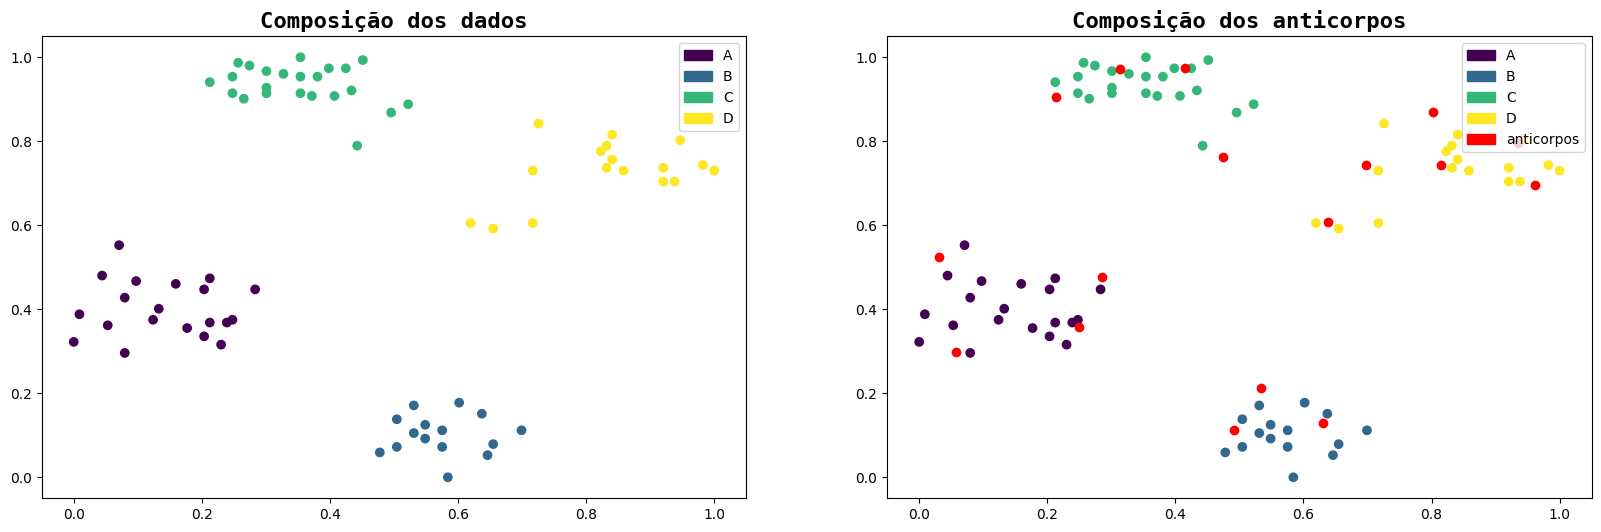

In [61]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Composição dos dados", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(122)

ab_x, ab_y = np.split(ab_population, 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])]

ax = plt.scatter(ab_x, ab_y, color="red")

plt.title("Composição dos anticorpos", fontdict=title_dict)
plt.legend(handles=[*handles, mpatches.Patch(color="red", label="anticorpos")], loc="upper right")

### Realizando agrupamento

#### Por limiar

In [62]:
mst_pruning_threshold = 0.05

##### Agrupamento obtido

In [63]:
t_labels = ainet.predict(normed_data[:, :2], mst_pruning_threshold=mst_pruning_threshold, mst_pruning_type="threshold")
print(f"Total de grupos encontrado: {len(np.unique(t_labels))}")
t_labels

Total de grupos encontrado: 6


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 5, 5, 3, 5, 3, 5, 5, 5, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 2, 2, 2, 2, 5, 5, 5, 5,
       5, 5, 5, 1, 1, 1, 1, 1, 1], dtype=int8)

##### Quantidade de vértices eliminados

In [64]:
t_ex_edges = ainet.mst_edges_deleted

t_ex_edges.shape

(9, 2)

In [65]:
t_antibody_labels = ainet.antibody_labels
t_antibody_labels.shape

(17,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

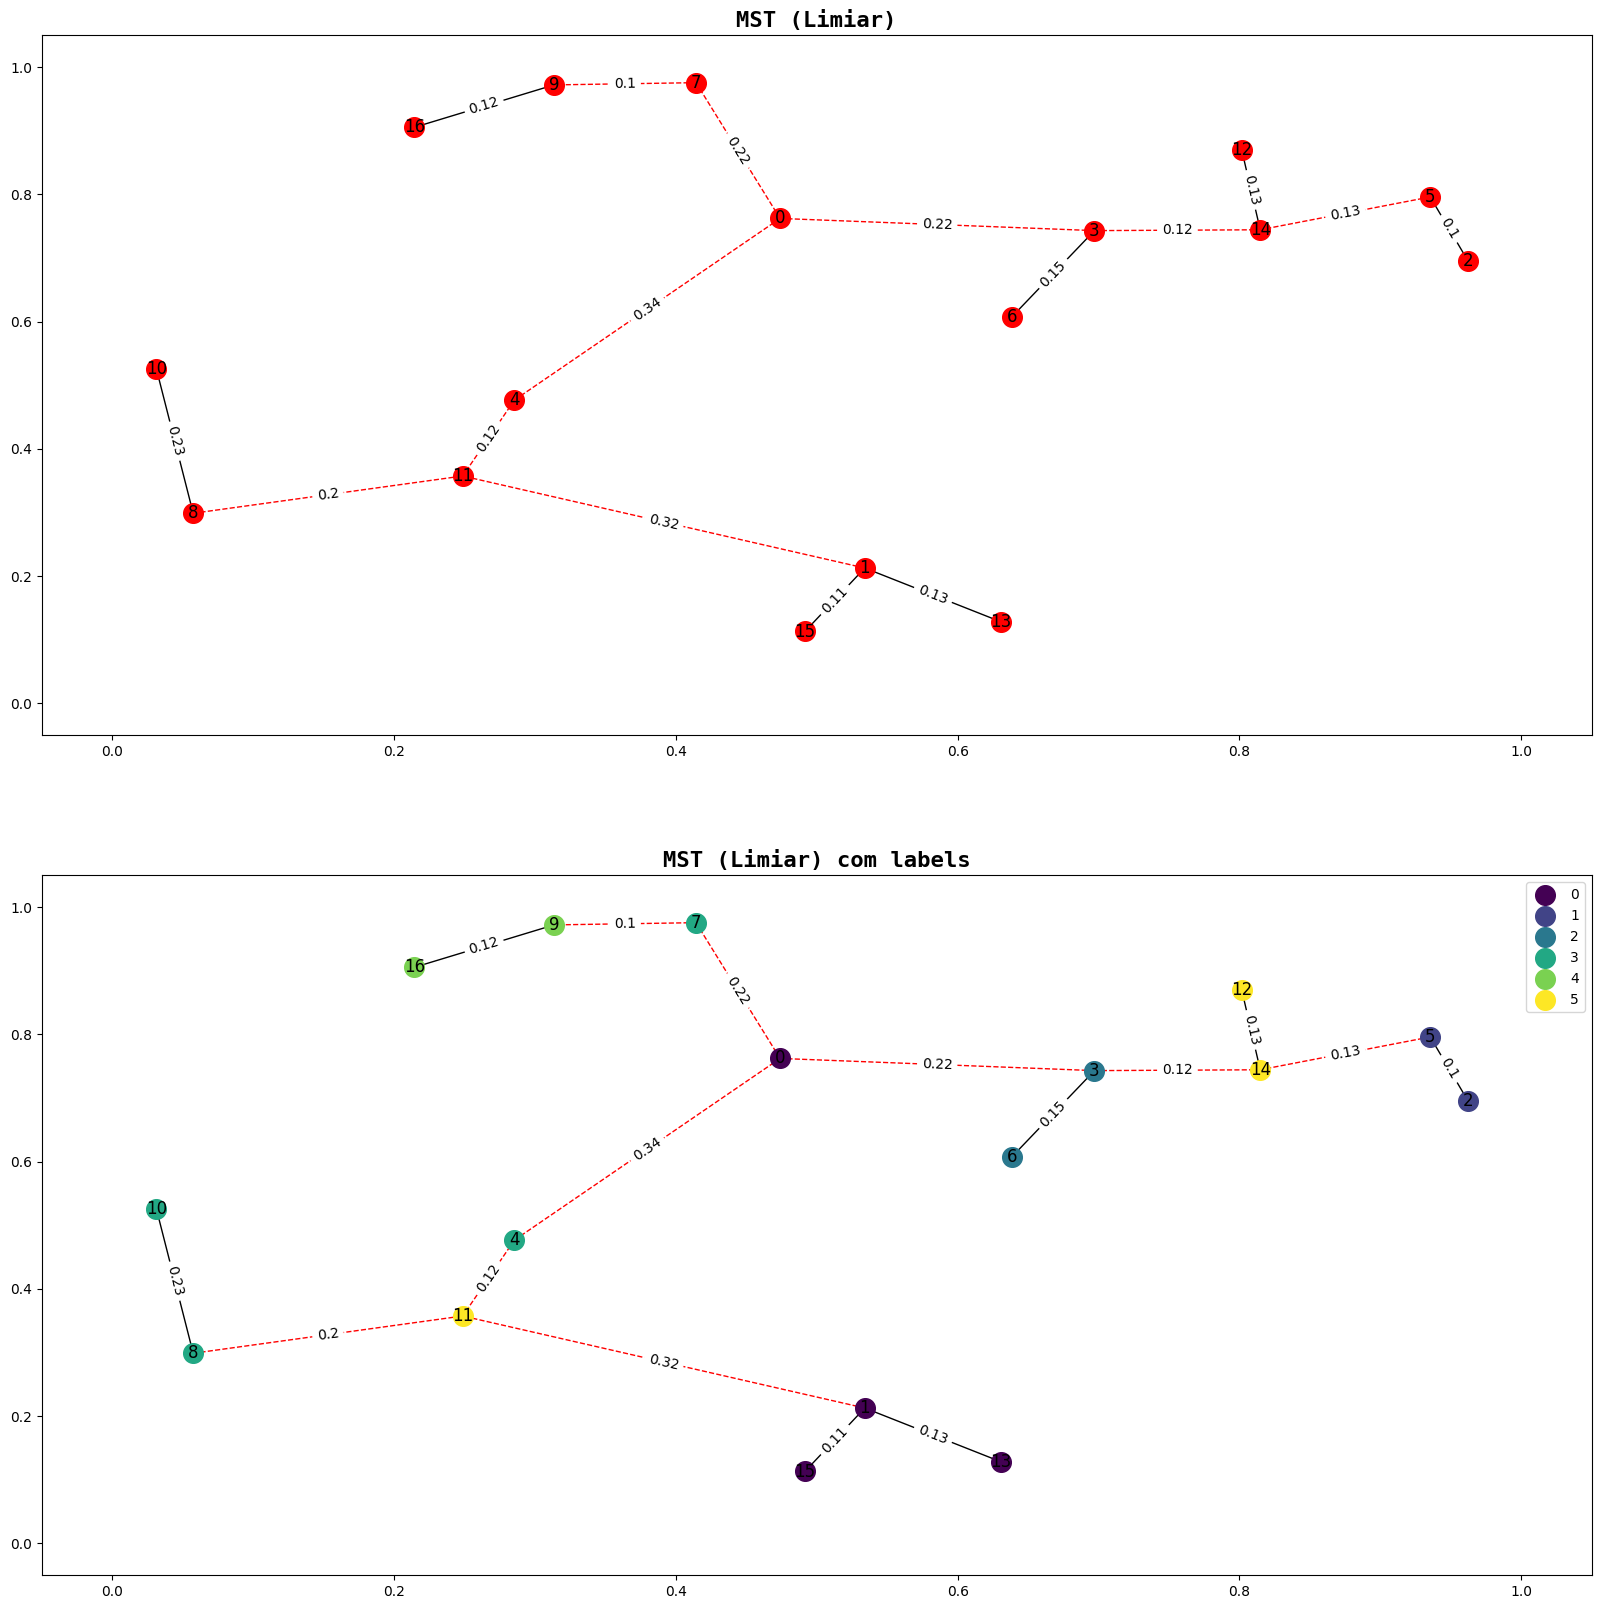

In [66]:
plt.figure(figsize=(20, 20))

plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges)

plt.title("MST (Limiar)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, t_ex_edges, t_antibody_labels)

plt.title("MST (Limiar) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

#### Por Desvio Padrão

In [67]:
mst_pruning_param = 1

##### Agrupamento obtido

In [68]:
labels = ainet.predict(normed_data[:, :2], mst_pruning_type="average", k=1.5)
print(f"Total de grupos encontrado: {len(np.unique(labels))}")
labels

Total de grupos encontrado: 4


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2], dtype=int8)

##### Quantidade de vértices eliminados

In [69]:
ex_edges = ainet.mst_edges_deleted
ex_edges.shape

(3, 2)

In [70]:
antibody_labels = ainet.antibody_labels
antibody_labels.shape

(17,)

##### Visualizações apresentando a distribuição dos dados e formação dos grupos

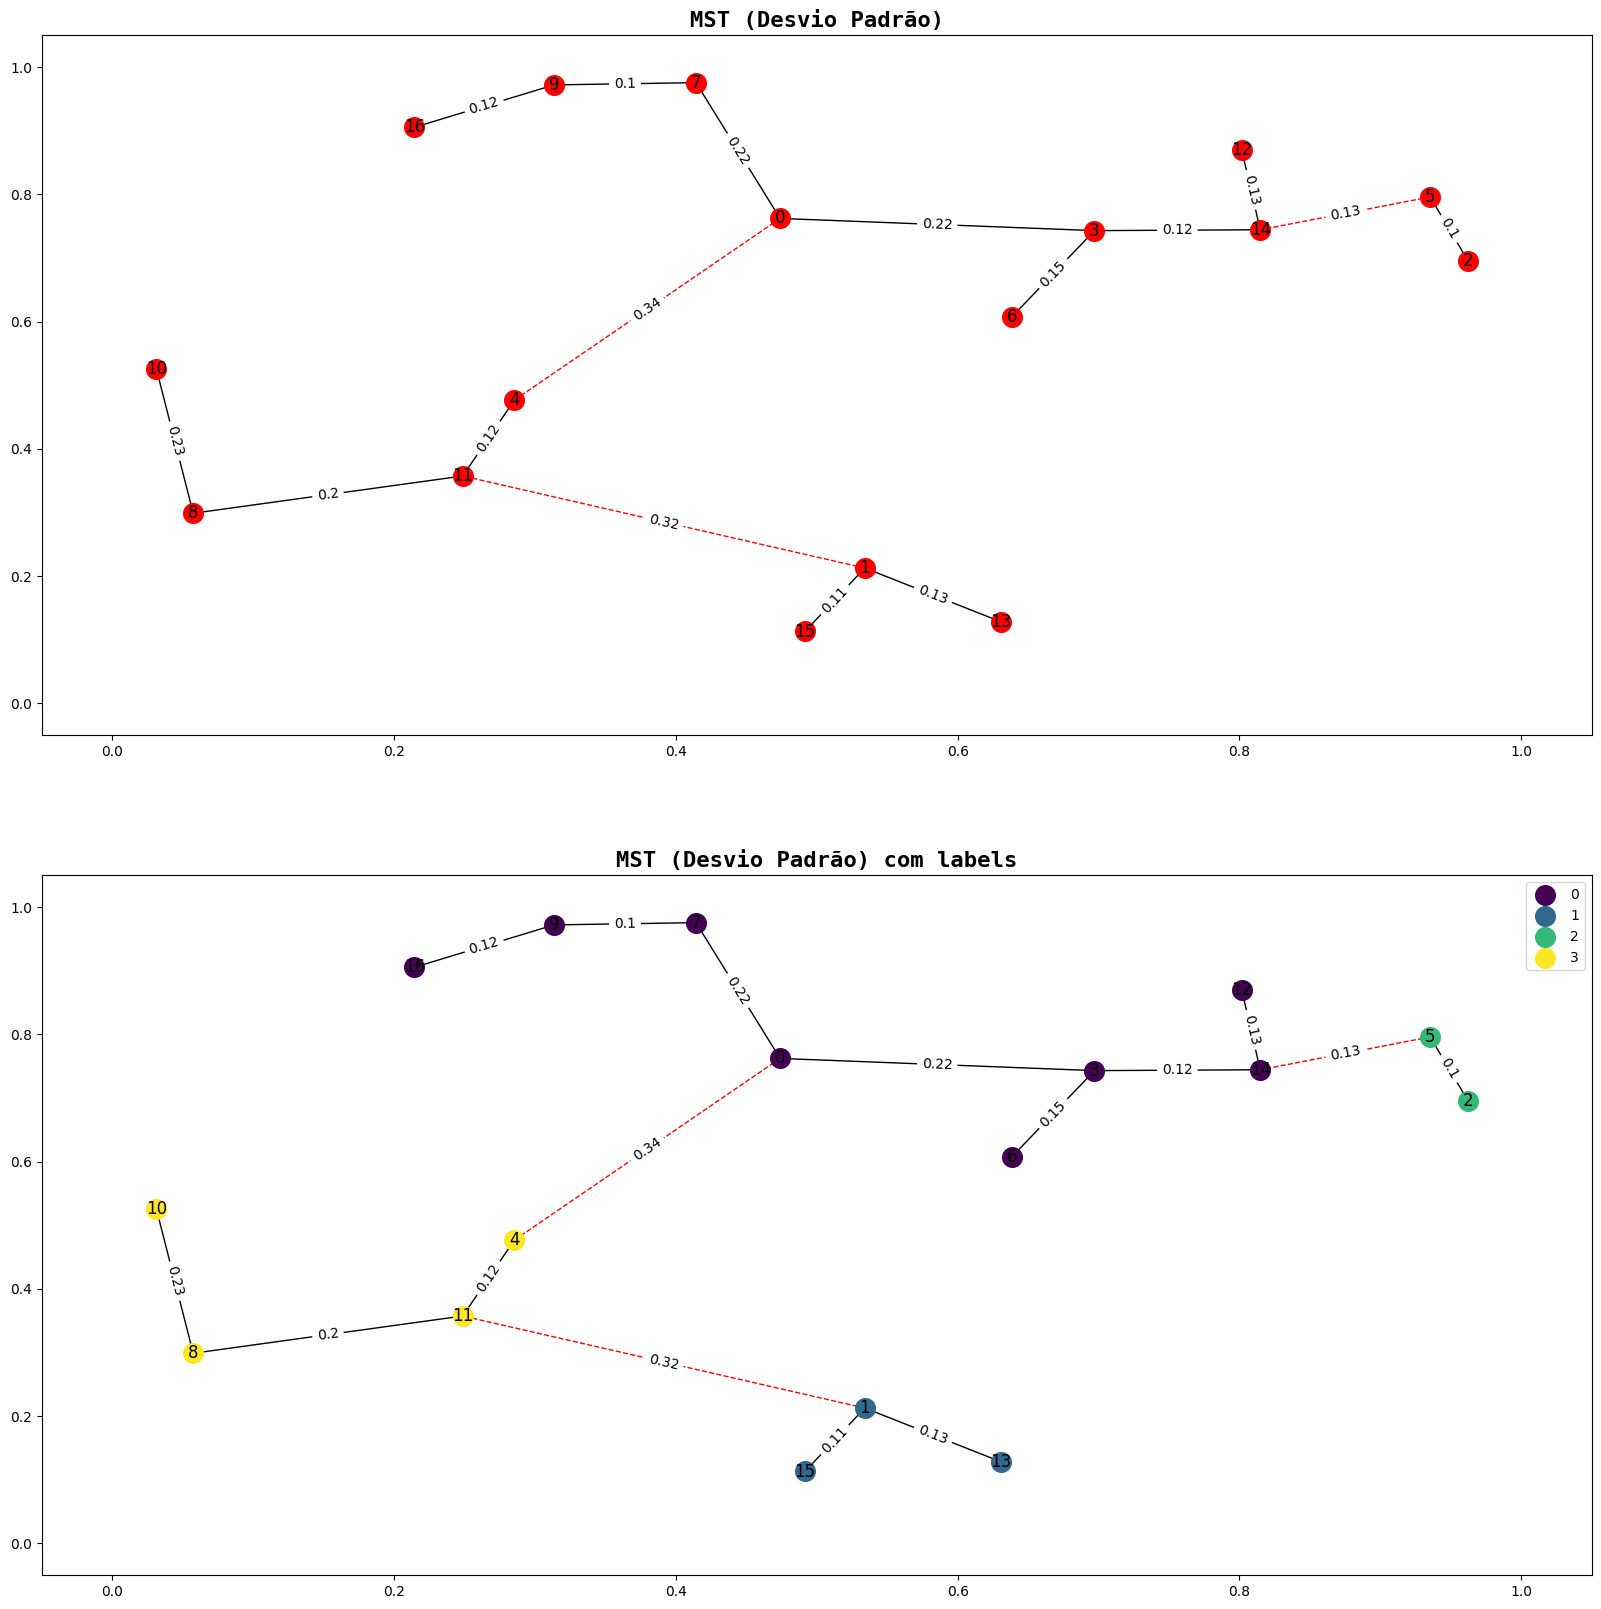

In [71]:
plt.figure(figsize=(20, 20))

plt.subplot(211)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges)

plt.title("MST (Desvio Padrão)", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.subplot(212)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plot_mst_graph(ainet, ex_edges, antibody_labels)

plt.title("MST (Desvio Padrão) com labels", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

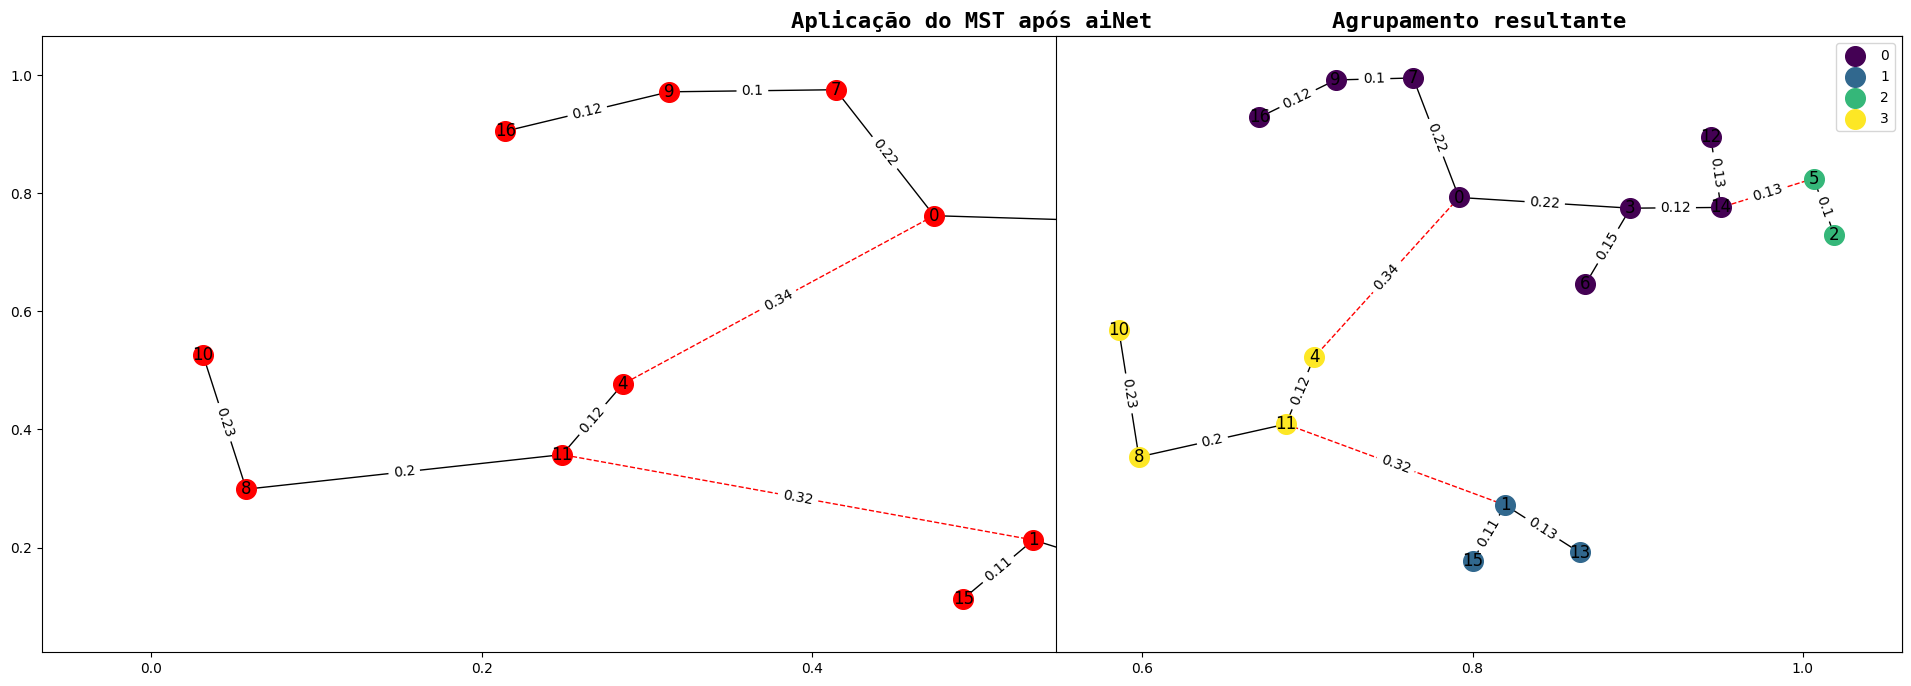

In [72]:
fig = plt.figure(figsize=(24, 8))

plot_mst_graph(ainet, ex_edges)

plt.title("Aplicação do MST após aiNet", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

ax = plt.subplot(122)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

ax.set_xticks([])
ax.set_yticks([])

plot_mst_graph(ainet, ex_edges, antibody_labels)

plt.title("Agrupamento resultante", fontdict=title_dict)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

fig.savefig("mst_result.png", dpi=400)

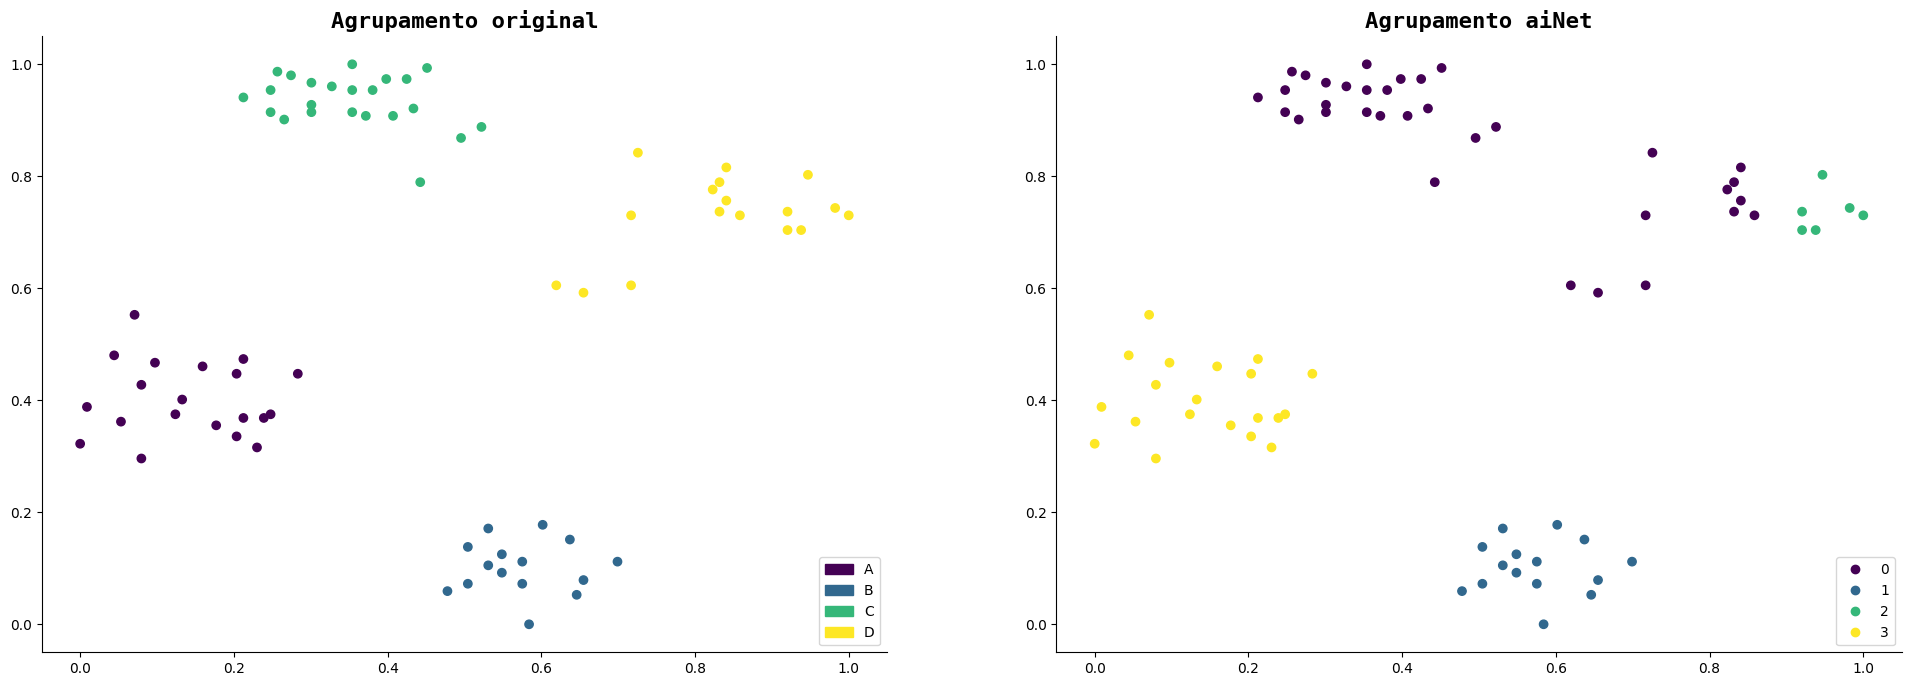

In [73]:
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

fig = plt.figure(figsize=(24, 8))

plt.subplot(121)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Agrupamento original", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])], loc="lower right")

plt.subplot(122)

scatter = plt.scatter(data_x, data_y, c=labels, cmap="viridis")
plt.title("Agrupamento aiNet", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="lower right")

fig.savefig("ruspini_result.png", dpi=400)

#### Comparação classificação

As arestas pintadas de vermelha foram as arestas eliminadas

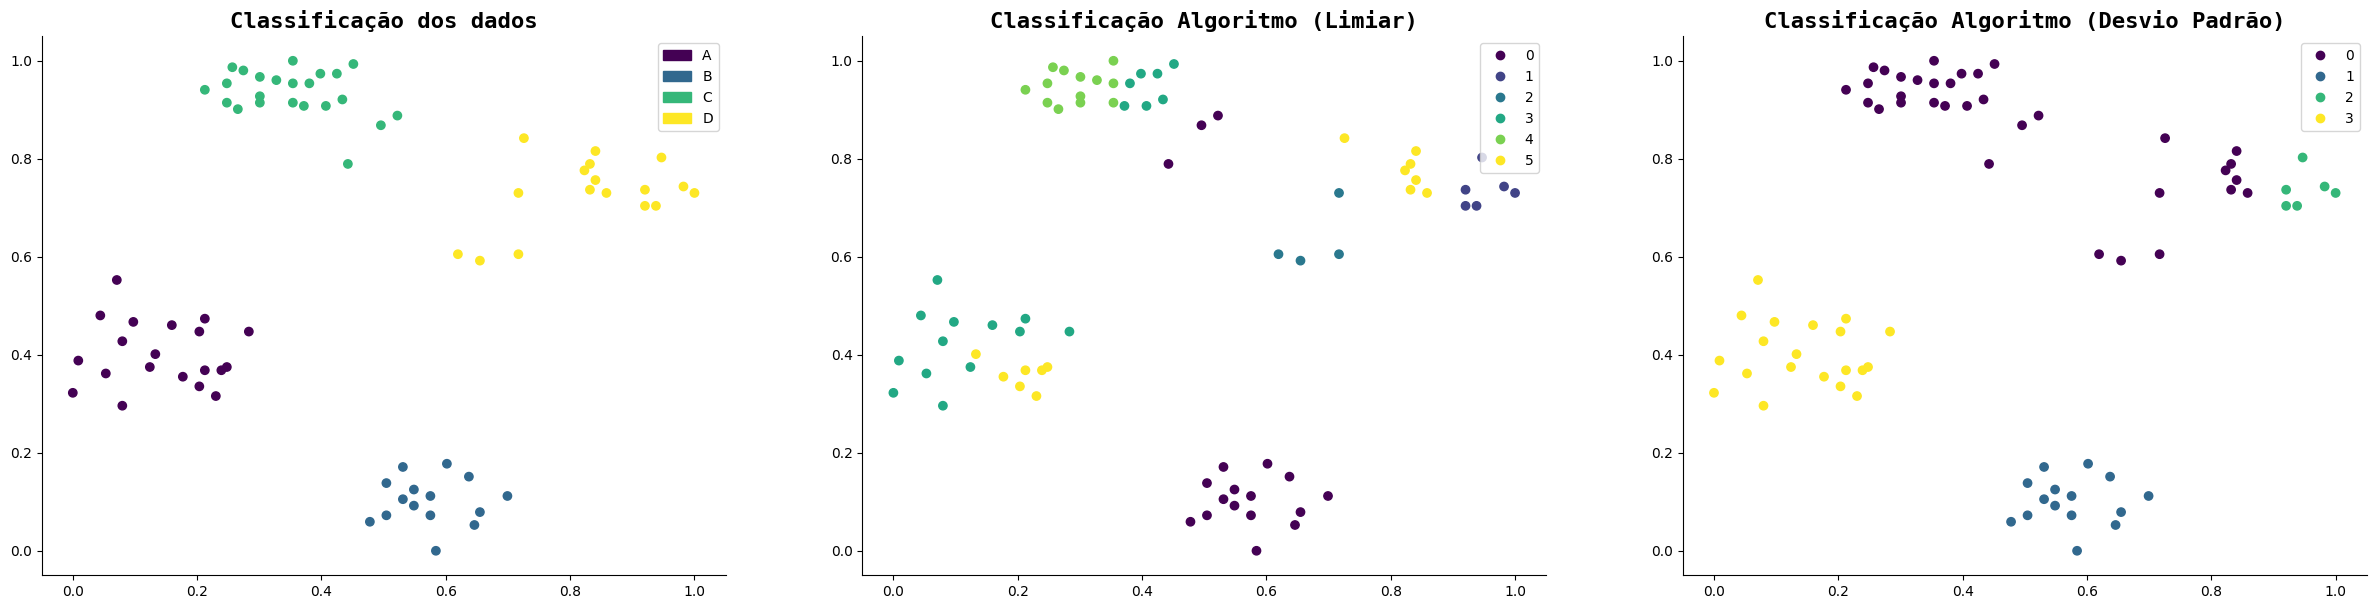

In [74]:
plt.figure(figsize=(30, 7))

plt.subplot(131)
data_x, data_y = np.split(normed_data[:, :2], 2, axis=1)

ax = plt.scatter(data_x, data_y, c=target, cmap="viridis")
plt.title("Classificação dos dados", fontdict=title_dict)
plt.legend(handles=[mpatches.Patch(color=handle._color, label=target_name[idx]) for idx, handle in enumerate(ax.legend_elements()[0])])

plt.subplot(132)

scatter = plt.scatter(data_x, data_y, c=t_labels, cmap="viridis")
plt.title("Classificação Algoritmo (Limiar)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(t_labels), loc="upper right")

plt.subplot(133)

scatter = plt.scatter(data_x, data_y, c=labels, cmap="viridis")
plt.title("Classificação Algoritmo (Desvio Padrão)", fontdict=title_dict)
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="upper right")